In [400]:
import pandas as pd 
import math

In [91]:
# read file 
addLiquidity = pd.read_csv('data/eth_addLiquidity.csv')
removeLiquidity = pd.read_csv('data/eth_removeLiquidity.csv')
swapData = pd.read_csv('data/eth_swap.csv')

In [408]:
# read file 
import os
os.path.abspath('')
# a = pd.read_csv('//data//eth_addLiquidity.csv')
# r = pd.read_csv('//data//eth_removeLiquidity.csv')
# s = pd.read_csv('//data//eth_swap.csv')

'/Users/johntzuyang/Desktop/code/Uniswap-MEV-Analysis-Origin'

In [98]:
# drop duplicates and sort by block_number first, then logIndex 
addLiquidity = addLiquidity.drop_duplicates(subset=["tx_hash"],keep="first")
addLiquidity = addLiquidity.sort_values(['block_number', 'logIndex'], ascending = [True, True])
removeLiquidity = removeLiquidity.drop_duplicates(subset=["tx_hash"],keep="first")
removeLiquidity = removeLiquidity.sort_values(['block_number', 'logIndex'], ascending = [True, True])
swapData = swapData.drop_duplicates(subset=["tx_hash"],keep="first")
swapData = swapData.sort_values(['block_number', 'log_index'], ascending = [True, True])

In [99]:
swapData['prevTick'] = swapData['tick'].shift()
swapData['prevPrice'] = swapData['price'].shift()
swapData = swapData.iloc[1:]

In [398]:
def priceToTick(price):
    tick = math.log(price/1e12)/(math.log(1.0001)) * (-1)
    return tick 

## JIT PnL Analysis

In [346]:
jitFeeIncomes = {}
gasCosts = {}
V3PnLs = {}

for index,value in addLiquidity.iterrows():
    (addBlock,
    addOrigin,
    addTickLower,
    addTickUpper,
    addLogIndex,
    addAmountUSD) = value['block_number'],value['origin'], value['tickLower'], value['tickUpper'], value['logIndex'],value['amountUSD']
    
    # JIT criteria
    sameBlock = removeLiquidity['block_number'] == addBlock
    sameOrigin = removeLiquidity['origin'] == addOrigin # same tx initiator 
    sameTickLower = removeLiquidity['tickLower'] == addTickLower
    sameTickUpper = removeLiquidity['tickUpper'] == addTickUpper
    addThenRemove = removeLiquidity['logIndex'] > addLogIndex
    
    sameBlockRemoveLiquidityEvent = removeLiquidity[sameBlock & sameOrigin & sameTickLower & sameTickUpper & addThenRemove]
    
    # LP add/remove liquidity in the same block
    if len(sameBlockRemoveLiquidityEvent) > 0: 
        removeLogIndex = sameBlockRemoveLiquidityEvent.iloc[0]['logIndex']
        removeAmountUSD = sameBlockRemoveLiquidityEvent.iloc[0]['amountUSD']
        # exploited swap criteria 
        swapAtSameBlock = swapData['block_number']==addBlock
        swapAfterAdd = swapData['log_index'] > addLogIndex
        swapBeforeRemove = swapData['log_index'] < removeLogIndex
        
        jitSwapData = swapData[swapAtSameBlock & swapAfterAdd & swapBeforeRemove]
        
        if len(jitSwapData) > 0:
            # traverse through all jit swap data and calculate fee income 
            jitFeeIncome = 0

            for i,v in jitSwapData.iterrows():
                tickBeforeSwap = priceToTick(v['prevPrice'])
                tickAfterSwap = priceToTick(v['price'])
                tickDiff = abs(tickAfterSwap - tickBeforeSwap)
                tickRange = addTickUpper - addTickLower
                jitFeeIncome += addAmountUSD * 0.0005 * (tickDiff / tickRange) 

            V3PnL = removeAmountUSD - addAmountUSD
            gasCost = v['price'] * 1/1e18 * (value['gasUsed'] * value['gasPrice'] + sameBlockRemoveLiquidityEvent.iloc[0]['gasUsed'] * sameBlockRemoveLiquidityEvent.iloc[0]['gasPrice'])
            
            jitFeeIncomes[value['timestamp']] = jitFeeIncome
            V3PnLs[value['timestamp']] = V3PnL
            gasCosts[value['timestamp']] = -1 * gasCost
            
    

In [347]:
totalDf = pd.DataFrame.from_dict(jitFeeIncomes, orient='index')
totalDf.columns = ['JIT Fee']
totalDf['JIT V3 PnL'] = list(V3PnLs.values())
totalDf['JIT Gas Cost'] = list(gasCosts.values())
totalDf['JIT Profit'] = totalDf['JIT Fee'] + totalDf['JIT Gas Cost'] + totalDf['JIT Gas Cost']

totalDf['Cumulative JIT Fee'] = totalDf['JIT Fee'].cumsum()
totalDf['Cumulative JIT V3 PnL'] = totalDf['JIT V3 PnL'].cumsum()
totalDf['Cumulative JIT Gas Cost'] = totalDf['JIT Gas Cost'].cumsum()
totalDf['Cumulative JIT Profit'] = totalDf['JIT Profit'].cumsum()
totalDf

,JIT Fee,JIT V3 PnL,JIT Gas Cost,JIT Profit,Cumulative JIT Fee,Cumulative JIT V3 PnL,Cumulative JIT Gas Cost,Cumulative JIT Profit
1651330195,170.720225,-892.156767,-250.237871,-329.755517,1.707202e+02,-892.156767,-250.237871,-3.297555e+02
1651354759,229.607539,285.739265,-216.945124,-204.282709,4.003278e+02,-606.417502,-467.182995,-5.340382e+02
1651396917,227.091900,863.287963,-192.240371,-157.388842,6.274197e+02,256.870461,-659.423366,-6.914271e+02
1651445433,180.614618,782.951561,-221.794364,-262.974111,8.080343e+02,1039.822022,-881.217731,-9.544012e+02
1651472064,5473.323912,144.060704,-167.814152,5137.695607,6.281358e+03,1183.882726,-1049.031883,4.183294e+03
...,...,...,...,...,...,...,...,...
1666773827,121.093869,-206.827831,-85.996138,-50.898407,2.254428e+06,542333.951633,-225928.656673,1.802570e+06
1666773839,47.223450,99.476289,-96.829569,-146.435688,2.254475e+06,542433.427922,-226025.486242,1.802424e+06
1666774427,23.515853,-109.433626,-60.809295,-98.102738,2.254498e+06,542323.994297,-226086.295537,1.802326e+06
1666774511,6912.082635,-93.422716,-32.142065,6847.798506,2.261410e+06,542230.571581,-226118.437602,1.809174e+06


In [344]:
# transform timestamp index to datetime index 
totalDf.index = pd.to_datetime((totalDf.index*1e9).astype(int))

### JIT Exploit in USDC

/var/folders/78/tjpvqbrx10g9y5084mq7ddw40000gn/T/ipykernel_83901/1363156815.py:9: UserWarning: 'set_params()' not defined for locator of type <class 'pandas.plotting._matplotlib.converter.PandasAutoDateLocator'>
  plt.locator_params(axis='x', nbins=30)


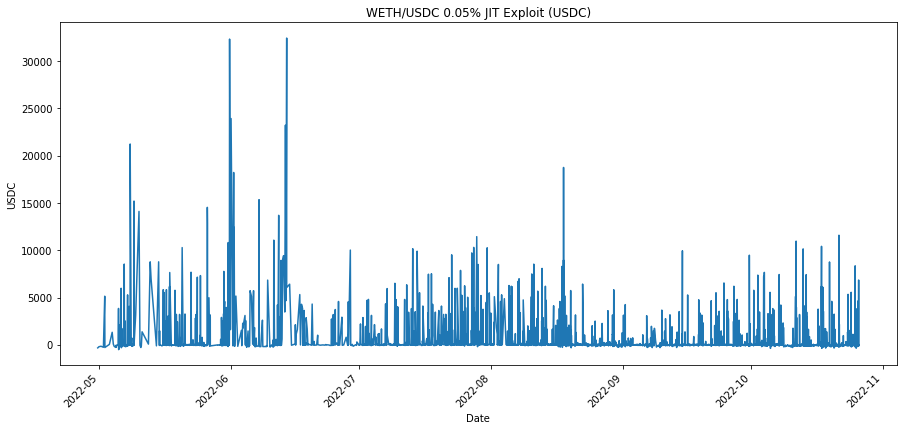

In [345]:
import matplotlib.pyplot as plt
totalDf['JIT Profit'].plot(
    figsize=(15,7),
    rot=45,
    title='WETH/USDC 0.05% JIT Exploit (USDC)',
    xlabel='Date',
    ylabel='USDC'
)
plt.locator_params(axis='x', nbins=30)
plt.show()

### JIT Cumulative Profit

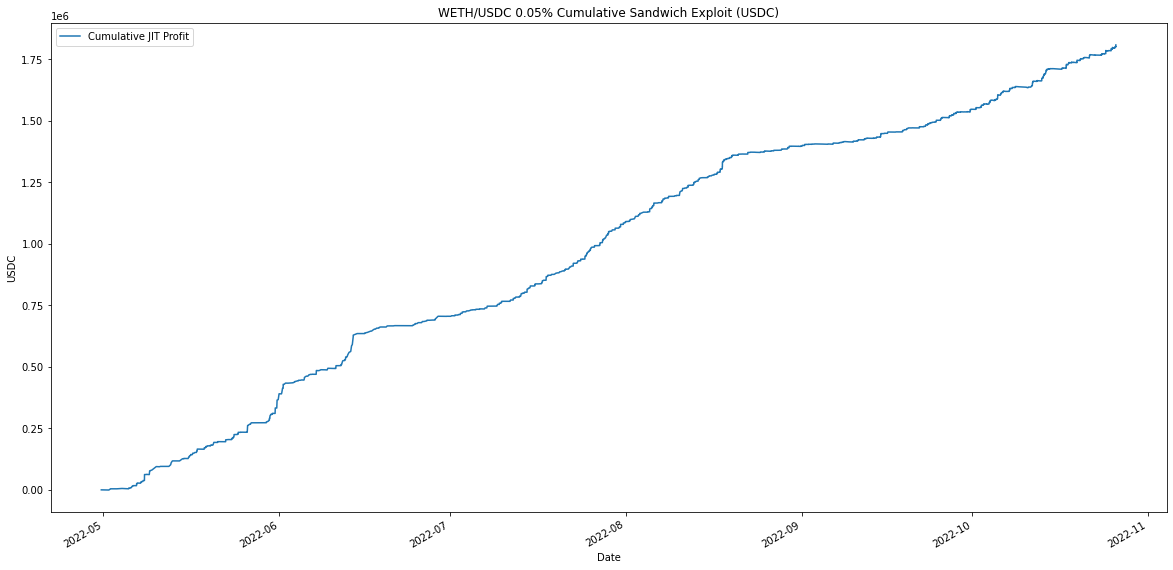

In [116]:
ax = totalDf[['Cumulative JIT Profit']].plot(figsize=(20,10),
                                              title='WETH/USDC 0.05% Cumulative Sandwich Exploit (USDC)',
                                              xlabel='Date',
                                              ylabel='USDC')

# Questions

## Q1: trader Analysis

In [142]:
def getJITTraderInto(addLiquidity,removeLiquidity,swapData):
    jitTraderInfo = {}
#     print("index | jitFeeIncome | V3PnL | gasCost")
    for index,value in addLiquidity.iterrows():
        (addBlock,
        addOrigin,
        addTickLower,
        addTickUpper,
        addLogIndex,
        addAmountUSD) = value['block_number'],value['origin'], value['tickLower'], value['tickUpper'], value['logIndex'],value['amountUSD']

        # JIT criteria
        sameBlock = removeLiquidity['block_number'] == addBlock
        sameOrigin = removeLiquidity['origin'] == addOrigin # same tx initiator 
        sameTickLower = removeLiquidity['tickLower'] == addTickLower
        sameTickUpper = removeLiquidity['tickUpper'] == addTickUpper
        addThenRemove = removeLiquidity['logIndex'] > addLogIndex

        sameBlockRemoveLiquidityEvent = removeLiquidity[sameBlock & sameOrigin & sameTickLower & sameTickUpper & addThenRemove]

        if len(sameBlockRemoveLiquidityEvent) > 0: # LP add/remove liquidity in the same block
            removeLogIndex = sameBlockRemoveLiquidityEvent.iloc[0]['logIndex']
            removeAmountUSD = sameBlockRemoveLiquidityEvent.iloc[0]['amountUSD']
            # exploited swap criteria 
            swapAtSameBlock = swapData['block_number']==addBlock
            swapAfterAdd = swapData['log_index'] > addLogIndex
            swapBeforeRemove = swapData['log_index'] < removeLogIndex

            jitSwapData = swapData[swapAtSameBlock & swapAfterAdd & swapBeforeRemove]

            if len(jitSwapData) > 0:
                # traverse through all jit swap data and calculate fee income 
                jitFeeIncome = 0

                for i,v in jitSwapData.iterrows():
                    tickBeforeSwap = priceToTick(v['prevPrice'])
                    tickAfterSwap = priceToTick(v['price'])
                    tickDiff = abs(tickAfterSwap - tickBeforeSwap)
                    tickRange = addTickUpper - addTickLower
                    jitFeeIncome += addAmountUSD * 0.0005 * (tickDiff / tickRange) 

                V3PnL = removeAmountUSD - addAmountUSD
                gasCost = v['price'] * 1/1e18 * (value['gasUsed'] * value['gasPrice'] + sameBlockRemoveLiquidityEvent.iloc[0]['gasUsed'] * sameBlockRemoveLiquidityEvent.iloc[0]['gasPrice'])

    #             jitFeeIncomes[value['timestamp']] = jitFeeIncome
    #             V3PnLs[value['timestamp']] = V3PnL
    #             gasCosts[value['timestamp']] = -1 * gasCost
                jitTrader = value['origin']

                jitTrade = {'jitFeeIncome':jitFeeIncome,
                            'V3PnL':V3PnL,
                            'gasCost':gasCost,
                            'Profit': jitFeeIncome + V3PnL + (-1 * gasCost),
                            'amountUSD': addAmountUSD,
                            'Return': (jitFeeIncome + V3PnL + (-1 * gasCost)) / addAmountUSD
                           }
                if jitTrader not in jitTraderInfo:
                    jitTraderInfo[jitTrader] = []

                jitTraderInfo[jitTrader].append(jitTrade)
    return jitTraderInfo
#                 print(index,jitFeeIncome,V3PnL,-1 * gasCost,addAmountUSD)#,gasCost)
    

In [143]:
jitTraderInfo = getJITTraderInto(addLiquidity,removeLiquidity,swapData)

In [167]:
traderProfits = {}
cumROI = {}
averageROI = {}

for trader in jitTraderInfo:
    for record in jitTraderInfo[trader]:
        if trader not in traderProfits:
            traderProfits[trader] = 0
            cumROI[trader] = 0 
            
        cumROI[trader] += record['Return']
        traderProfits[trader] += record['Profit']
    
    averageROI[trader] = cumROI[trader] / len(jitTraderInfo[trader])
    
traderProfits = dict(sorted(traderProfits.items(), key=lambda item: item[1],reverse=True))

traderDf = pd.DataFrame.from_dict(traderProfits, orient='index')
traderDf.columns = ['Cumulative Profit (USD)']
traderDf['Cumulative ROI (%)'] = [cumROI[i]*100 for i in list(traderDf.index)]
traderDf['Average ROI (%)'] = [averageROI[i]*100 for i in list(traderDf.index)]
traderDf['JIT Count'] = (traderDf['Cumulative ROI (%)'] // traderDf['Average ROI (%)'])
traderDf[:20]

,Cumulative Profit (USD),Cumulative ROI (%),Average ROI (%),JIT Count
0x36a454aef52938c8637cd4689b2980c1cfd43389,180144.399480,0.725370,0.003573,203.0
0x93f635372008b7c5d770aaa6ff313454c8dc498c,179166.764066,0.729200,0.003489,209.0
0x431b5a84acc1297eda88259f300262f1bc3a74f3,169207.255782,0.702898,0.002800,251.0
0x60b86af869f23aeb552fb7f3cabd11b829f6ab2f,159812.456803,0.747666,0.003815,196.0
0xa5a13f62ce1113838e0d9b4559b8caf5f76463c0,150706.718397,0.611184,0.003041,201.0
0x43e4715ae093a4c86b5ecddb52216c4f879e9672,146098.327219,0.600745,0.002706,222.0
0x1c8f6a5f009e051cab9c3851ca2da2c936b2775a,128127.247345,0.608862,0.003364,181.0
0xafdc6373e653fcbd4583f41e2a5742cfcb5effc7,128076.761711,0.332238,0.030203,11.0
0xeca2e2d894d19778939bd4dfc34d2a3c45e96456,126598.699832,0.515097,0.002575,199.0
0x4603180bbb8221157880afaa84638e0fc467738d,123011.737415,0.359993,0.001756,205.0


### Top 20 Trader Trade Percentage

In [399]:
traderDf[:20]['JIT Count'].sum()/traderDf['JIT Count'].sum()

0.8868085106382979

## Q2: JIT Liquidity Analysis

In [394]:
def getJITPnL(addLiquidity,removeLiquidity,swapData):

    jitFeeIncomes = {}
    gasCosts = {}
    V3PnLs = {}
    jitLiquidity = {}
    jitSwapAmount = {}
    tickRanges = {}
    tickDistances = {}
    for index,value in addLiquidity.iterrows():
        (addBlock,
        addOrigin,
        addTickLower,
        addTickUpper,
        addLogIndex,
        addAmountUSD) = value['block_number'],value['origin'], value['tickLower'], value['tickUpper'], value['logIndex'],value['amountUSD']

        # JIT criteria
        sameBlock = removeLiquidity['block_number'] == addBlock
        sameOrigin = removeLiquidity['origin'] == addOrigin # same tx initiator 
        sameTickLower = removeLiquidity['tickLower'] == addTickLower
        sameTickUpper = removeLiquidity['tickUpper'] == addTickUpper
        addThenRemove = removeLiquidity['logIndex'] > addLogIndex

        sameBlockRemoveLiquidityEvent = removeLiquidity[sameBlock & sameOrigin & sameTickLower & sameTickUpper & addThenRemove]

        if len(sameBlockRemoveLiquidityEvent) > 0: # LP add/remove liquidity in the same block
            removeLogIndex = sameBlockRemoveLiquidityEvent.iloc[0]['logIndex']
            removeAmountUSD = sameBlockRemoveLiquidityEvent.iloc[0]['amountUSD']
            # exploited swap criteria 
            swapAtSameBlock = swapData['block_number']==addBlock
            swapAfterAdd = swapData['log_index'] > addLogIndex
            swapBeforeRemove = swapData['log_index'] < removeLogIndex

            jitSwapData = swapData[swapAtSameBlock & swapAfterAdd & swapBeforeRemove]
#             print(addTickUpper-addTickLower)
            if len(jitSwapData) > 0:
                # traverse through all jit swap data and calculate fee income 
                jitFeeIncome = 0
                swapAmount = 0 
                for i,v in jitSwapData.iterrows():
                    tickBeforeSwap = priceToTick(v['prevPrice'])
                    tickAfterSwap = priceToTick(v['price'])
                    tickDiff = abs(tickAfterSwap - tickBeforeSwap)
                    tickRange = addTickUpper - addTickLower
                    jitFeeIncome += addAmountUSD * 0.0005 * (tickDiff / tickRange) 
                    swapAmount += abs(v['amount0']) + abs(v['amount1'] * v['price']) # the swap volume that got jited
                V3PnL = removeAmountUSD - addAmountUSD
                gasCost = v['price'] * 1/1e18 * (value['gasUsed'] * value['gasPrice'] + sameBlockRemoveLiquidityEvent.iloc[0]['gasUsed'] * sameBlockRemoveLiquidityEvent.iloc[0]['gasPrice'])

                jitFeeIncomes[value['timestamp']] = jitFeeIncome
                V3PnLs[value['timestamp']] = V3PnL
                gasCosts[value['timestamp']] = -1 * gasCost
                jitLiquidity[value['timestamp']] = addAmountUSD
                jitSwapAmount[value['timestamp']] = swapAmount
                tickRanges[value['timestamp']] = tickRange
                
                initialTick = abs(jitSwapData.iloc[0]['prevTick'])
                tickDistance = initialTick-addTickLower
                tickDistances[value['timestamp']] = tickDistance


    return jitFeeIncomes, V3PnLs, gasCosts, jitLiquidity, jitSwapAmount, tickRanges,tickDistances
    

In [351]:
jitFeeIncomes, V3PnLs, gasCosts, jitLiquidity, jitSwapAmount,tickRanges, tickDistances = getJITPnL(addLiquidity,removeLiquidity,swapData)

In [266]:
totalDf = pd.DataFrame.from_dict(jitFeeIncomes, orient='index')
totalDf.columns = ['JIT Fee']
totalDf['JIT V3 PnL'] = list(V3PnLs.values())
totalDf['JIT Gas Cost'] = list(gasCosts.values())
totalDf['JIT Profit'] = totalDf['JIT Fee'] + totalDf['JIT Gas Cost'] + totalDf['JIT Gas Cost']
totalDf['JIT Swap Amount'] = list(jitSwapAmount.values())
totalDf['Cumulative JIT Fee'] = totalDf['JIT Fee'].cumsum()
totalDf['Cumulative JIT V3 PnL'] = totalDf['JIT V3 PnL'].cumsum()
totalDf['Cumulative JIT Gas Cost'] = totalDf['JIT Gas Cost'].cumsum()
totalDf['Cumulative JIT Profit'] = totalDf['JIT Profit'].cumsum()

totalDf

,JIT Fee,JIT V3 PnL,JIT Gas Cost,JIT Profit,JIT Swap Amount,Cumulative JIT Fee,Cumulative JIT V3 PnL,Cumulative JIT Gas Cost,Cumulative JIT Profit
1651330195,170.720225,-892.156767,-250.237871,-329.755517,694063.023694,1.707202e+02,-892.156767,-250.237871,-3.297555e+02
1651354759,229.607539,285.739265,-216.945124,-204.282709,614006.503070,4.003278e+02,-606.417502,-467.182995,-5.340382e+02
1651396917,227.091900,863.287963,-192.240371,-157.388842,918875.532386,6.274197e+02,256.870461,-659.423366,-6.914271e+02
1651445433,180.614618,782.951561,-221.794364,-262.974111,773719.136779,8.080343e+02,1039.822022,-881.217731,-9.544012e+02
1651472064,5473.323912,144.060704,-167.814152,5137.695607,799820.246206,6.281358e+03,1183.882726,-1049.031883,4.183294e+03
...,...,...,...,...,...,...,...,...,...
1666773827,121.093869,-206.827831,-85.996138,-50.898407,412812.390033,2.254428e+06,542333.951633,-225928.656673,1.802570e+06
1666773839,47.223450,99.476289,-96.829569,-146.435688,199950.781507,2.254475e+06,542433.427922,-226025.486242,1.802424e+06
1666774427,23.515853,-109.433626,-60.809295,-98.102738,98775.458698,2.254498e+06,542323.994297,-226086.295537,1.802326e+06
1666774511,6912.082635,-93.422716,-32.142065,6847.798506,685899.699363,2.261410e+06,542230.571581,-226118.437602,1.809174e+06


In [216]:
jitLiquidityRatio = {}
startTime = 1651276800 # 2022/04/30 00:00 utc+0
endTime = startTime + 86400 

while startTime < swapData.iloc[-1]['block_time']:
    isStart = swapData['block_time'] > startTime
    isEnd = swapData['block_time'] < endTime
    
    dailySwapData = swapData[isStart & isEnd]
    dailySwapVolume = (abs(dailySwapData['amount0']) + abs(dailySwapData['amount1']) * dailySwapData['price']).sum()
    dailyJITLiquidity = 0 
    for key in jitLiquidity:
        if key > startTime and key < endTime:
            dailyJITLiquidity += jitLiquidity[key]
            
    jitLiquidityRatio[startTime] = dailyJITLiquidity / dailySwapVolume * 100
    # reiterate
    startTime = endTime
    endTime += 86400

<AxesSubplot:title={'center':'Daily JIT Liquidity / Daily Trading Volume'}, xlabel='date', ylabel='(%)'>

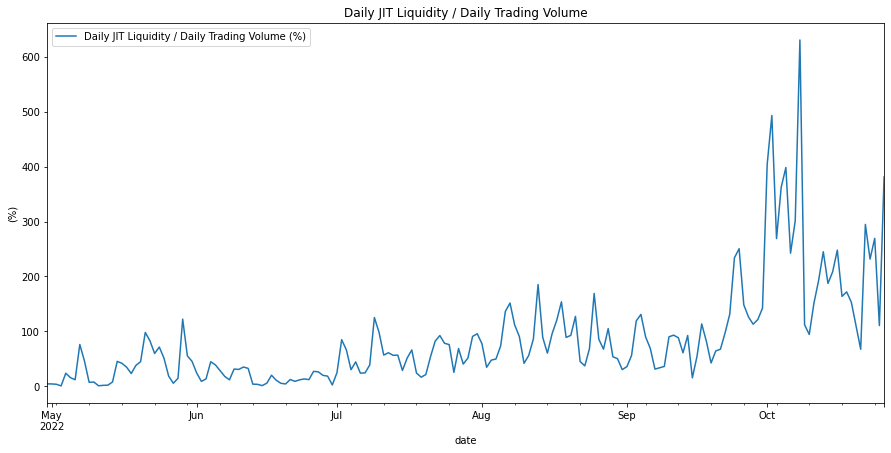

In [247]:
jitLiquidityRatioDf = pd.DataFrame.from_dict(jitLiquidityRatio, orient='index')
jitLiquidityRatioDf.columns=['Daily JIT Liquidity / Daily Trading Volume (%)']
jitLiquidityRatioDf.index = pd.to_datetime((jitLiquidityRatioDf.index*1e9).astype(int))
jitLiquidityRatioDf.plot(figsize=(15,7),xlabel='date',ylabel='(%)',title='Daily JIT Liquidity / Daily Trading Volume')

## Q3: Gas Cost/ Swap Amount and Profitability
The rationale behind this is that when a JIT trader spots on a large swap in mempool, he will know the approximated gas cost and the swap amount in advance. 

When gas cost is too high compared to the swap amount (which implies the potential profit for this JIT), the JIT attempt should lead to less profit or even causing JIT traders to lose money. We believe these two parameters should be embedded in these JIT traders’ algorithms.


In [267]:
totalDf

,JIT Fee,JIT V3 PnL,JIT Gas Cost,JIT Profit,JIT Swap Amount,Cumulative JIT Fee,Cumulative JIT V3 PnL,Cumulative JIT Gas Cost,Cumulative JIT Profit
1651330195,170.720225,-892.156767,-250.237871,-329.755517,694063.023694,1.707202e+02,-892.156767,-250.237871,-3.297555e+02
1651354759,229.607539,285.739265,-216.945124,-204.282709,614006.503070,4.003278e+02,-606.417502,-467.182995,-5.340382e+02
1651396917,227.091900,863.287963,-192.240371,-157.388842,918875.532386,6.274197e+02,256.870461,-659.423366,-6.914271e+02
1651445433,180.614618,782.951561,-221.794364,-262.974111,773719.136779,8.080343e+02,1039.822022,-881.217731,-9.544012e+02
1651472064,5473.323912,144.060704,-167.814152,5137.695607,799820.246206,6.281358e+03,1183.882726,-1049.031883,4.183294e+03
...,...,...,...,...,...,...,...,...,...
1666773827,121.093869,-206.827831,-85.996138,-50.898407,412812.390033,2.254428e+06,542333.951633,-225928.656673,1.802570e+06
1666773839,47.223450,99.476289,-96.829569,-146.435688,199950.781507,2.254475e+06,542433.427922,-226025.486242,1.802424e+06
1666774427,23.515853,-109.433626,-60.809295,-98.102738,98775.458698,2.254498e+06,542323.994297,-226086.295537,1.802326e+06
1666774511,6912.082635,-93.422716,-32.142065,6847.798506,685899.699363,2.261410e+06,542230.571581,-226118.437602,1.809174e+06


<AxesSubplot:title={'center':'Gas/Swap Ratio and Profit Analysis'}, xlabel='gasSwapRatio', ylabel='Profit (USDC)'>

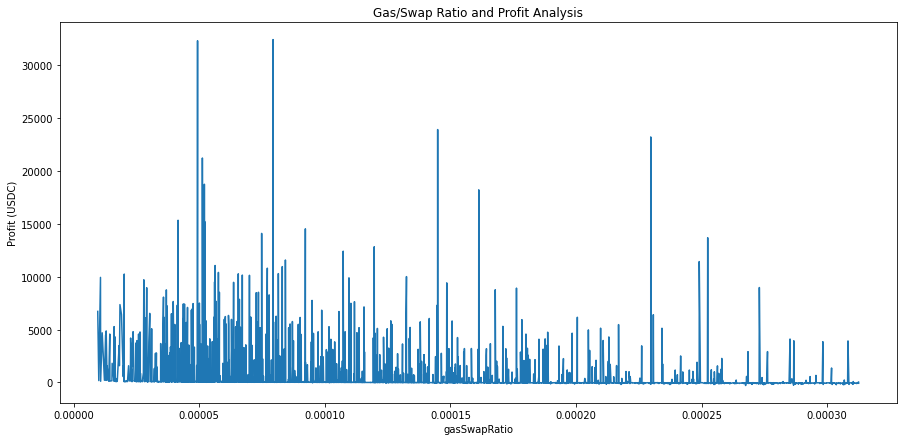

In [310]:
gasSwapRatio = list((abs(totalDf['JIT Gas Cost']) / totalDf['JIT Swap Amount'])) # x
jitProfit = list(totalDf['JIT Profit']) # y 
gasProfitDf = pd.DataFrame({'gasSwapRatio':gasSwapRatio,
                            'jitProfit':jitProfit})

gasProfitDf = gasProfitDf.sort_values(['gasSwapRatio'], ascending = [True])
gasProfitDf.index = gasProfitDf['gasSwapRatio']

gasProfitDf['jitProfit'].iloc[:-1000].plot(figsize=(15,7),title='Gas/Swap Ratio and Profit Analysis',ylabel='Profit (USDC)')

<AxesSubplot:title={'center':'Gas/Swap Ratio and Profit Analysis (Positive Profit Ones)'}, xlabel='gasSwapRatio', ylabel='Profit (USDC)'>

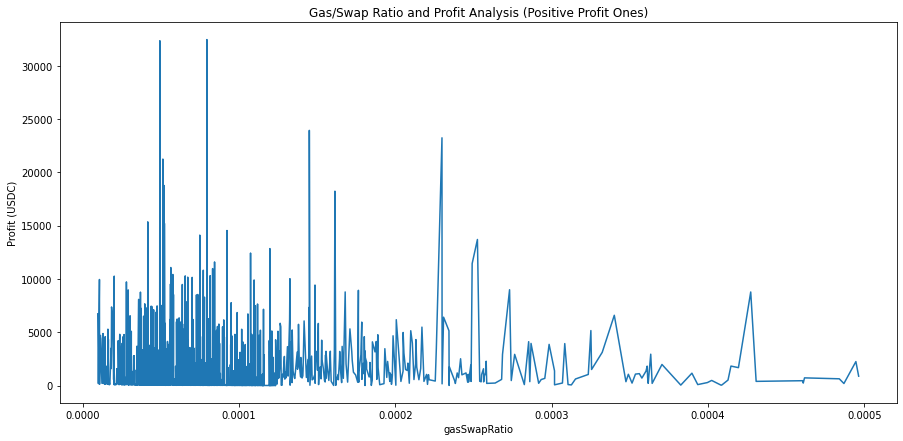

In [319]:
positiveGasProfitDf = gasProfitDf[gasProfitDf['jitProfit']>0]
positiveGasProfitDf

positiveGasProfitDf['jitProfit'].iloc[:-10].plot(figsize=(15,7),title='Gas/Swap Ratio and Profit Analysis (Positive Profit Ones)',ylabel='Profit (USDC)')

<AxesSubplot:title={'center':'Gas/Swap Ratio and Profit Analysis (Negative Profit Ones)'}, xlabel='gasSwapRatio', ylabel='Profit (USDC)'>

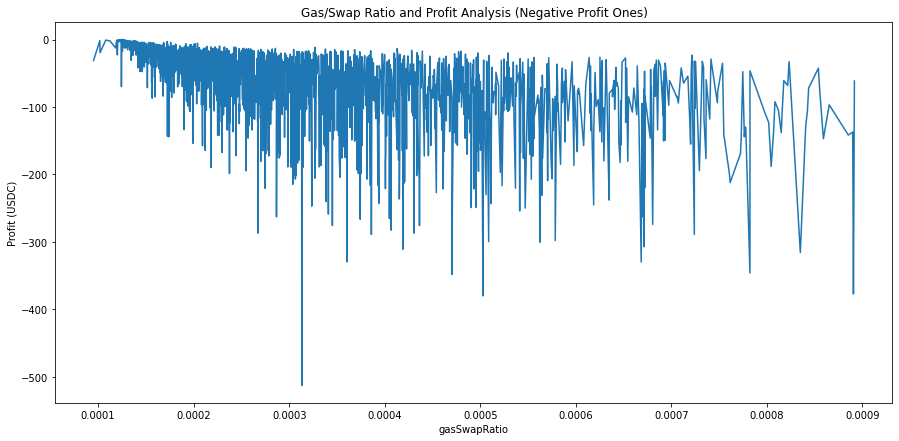

In [316]:
negativeGasProfitDf = gasProfitDf[gasProfitDf['jitProfit']<0]
negativeGasProfitDf

negativeGasProfitDf['jitProfit'].iloc[:-10].plot(figsize=(15,7),title='Gas/Swap Ratio and Profit Analysis (Negative Profit Ones)',ylabel='Profit (USDC)')

## Q4: JIT's Impact on LP

### Q4-1: General picture in the last 6 months

In [233]:
totalTradingVolume = (abs(swapData['amount0']) + abs(swapData['amount1'] * swapData['price'])).sum()
totalLPFee = totalTradingVolume * 0.0005
totalJITFee = sum(list(jitFeeIncomes.values()))
jitFeeRatio = totalJITFee / totalLPFee

print('Total LP Fee ($): ',totalLPFee)
print('Total JIT Fee ($): ',totalJITFee)
print('JIT Fee Ratio (%): ',jitFeeRatio)

Total LP Fee ($):  100090974.8680468
Total JIT Fee ($):  2261484.7426152327
JIT Fee Ratio (%):  0.022594292298547616


### Q4-2: Daily data in the past 6 months

In [248]:
jitFeeRatio = {}
startTime = 1651276800 # 2022/04/30 00:00 utc+0
endTime = startTime + 86400 

while startTime < swapData.iloc[-1]['block_time']:
    isStart = swapData['block_time'] > startTime
    isEnd = swapData['block_time'] < endTime
    
    dailySwapData = swapData[isStart & isEnd]
    dailySwapVolume = (abs(dailySwapData['amount0']) + abs(dailySwapData['amount1']) * dailySwapData['price']).sum()
    dailySwapFee = dailySwapVolume * 0.0005
    isStart = totalDf.index > startTime
    isEnd = totalDf.index < endTime
    dailyJITFee = totalDf[isStart & isEnd]['JIT Fee'].sum()
            
#     jitLiquidityRatio[startTime] = {'jitLiquidity':dailyJITLiquidity,
#                                     'allLiquidity':dailyAddLiquidity,
#                                     'jitLiquidityRatio': dailyJITLiquidity / dailyAddLiquidity}
    jitFeeRatio[startTime] = dailyJITFee / dailySwapFee * 100
    # reiterate
    startTime = endTime
    endTime += 86400

<AxesSubplot:title={'center':'Daily JIT Fee / Total LP Fee'}, xlabel='Date', ylabel='(%)'>

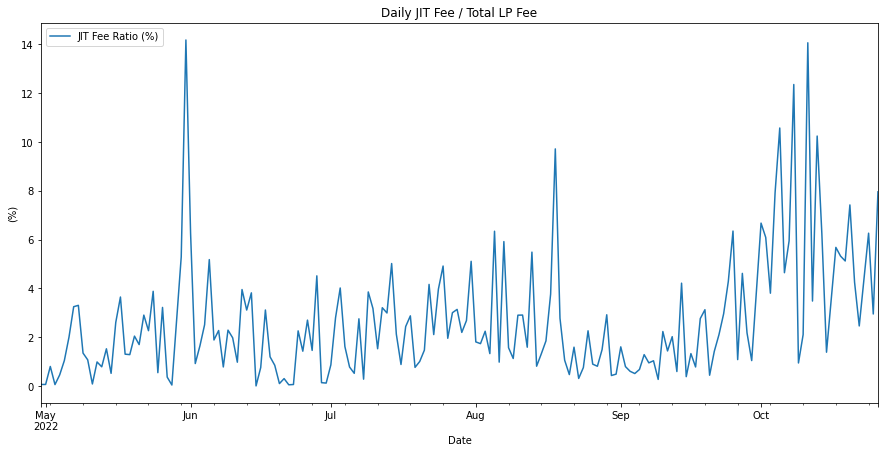

In [255]:
FeeRatioDf = pd.DataFrame.from_dict(jitFeeRatio, orient='index')
FeeRatioDf.columns = ['JIT Fee Ratio (%)']
FeeRatioDf.index = pd.to_datetime((FeeRatioDf.index*1e9).astype(int))
FeeRatioDf.plot(figsize=(15,7),
                xlabel='Date',
                ylabel='(%)',
                title='Daily JIT Fee / Total LP Fee')

In [254]:
FeeRatioDf['JIT Fee Ratio (%)'].sum()/len(FeeRatioDf)

2.660201090756558

## Q5: JIT tick range Analysis

In [ ]:
jitFeeIncomes, V3PnLs, gasCosts, jitLiquidity, jitSwapAmount,jitTickRanges = getJITPnL(addLiquidity,removeLiquidity,swapData)

In [332]:
tickCountdict = {}
for time in jitTickRanges:
    tick = jitTickRanges[time]
    if tick not in adict:
        tickCount[tick] = 1
    else:
        tickCount[tick] += 1
tickCount

{10: 4666}